# D603 Task 3 - Time Series Modeling

In [ ]:
# --- Environment ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import itertools
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

## A. GitLab Repository

https://gitlab.com/wgu-gitlab-environment/student-repos/smurd32/d603-machine-learning/-/tree/task-3-time-series?ref_type=heads

Note: See branch history as separate file in submission.

## B. Purpose of Data Analysis

### B1. Research Question

**Research Question:** "What underlying patterns, such as trends and seasonality, exist in the hospital's daily revenue data, and can a time series model be developed to accurately forecast future revenue?"

### B2. Objectives and Goals

- **Explore the Data's Characteristics:** I'll start by performing an exploratory data analysis (EDA) on the time series data. The goal here is to visualize the data and identify any underlying patterns, such as trends (long-term increase or decrease in revenue), seasonality (predictable, repeating patterns), and any unusual data points or outliers. This will give us a foundational understanding of the hospital's revenue behavior.

- **Develop a Predictive Model:** Based on the insights from my exploration, I will select and build an appropriate time series model. The objective is to create a model that accurately captures the identified trends and seasonality in the daily revenue data.

- **Forecast Future Revenue:** The ultimate goal is to use the model to generate reliable forecasts for future daily revenue. This will provide the hospital executives with a valuable tool for financial planning and decision-making, especially in the context of managing readmission penalties.

- **Evaluate Model Performance:** I will assess the accuracy of the forecasting model to ensure its predictions are reliable and useful for the hospital's strategic planning.


## C. Summary of Assumptions

Time series models, like many statistical models, have a few key assumptions that need to be met for them to produce reliable results.

**Stationarity:** This is a fundamental concept in time series analysis. A time series is considered "stationary" if its statistical properties--specifically the mean, variance, and covariance--remain constant over time.

- **Constant mean:** The series doesn't have a long-term trend upwards or downwards. It fluctuates around a consistent average.

- **Constant Variance:** THe spread or volatility of the data doesn't change over time. The fluctuations are of a similar size throughout the series.

A stationary series is like a stable, predictable system. A non-stationary series, on the other hand, might have a trend or changing volatility, which makes it harder to model accurately wihtout first transforming it.

**Autocorrelation:** This assumption is what makes time series forecasting possible. Autocorrelation simply means that the data points in the series are correlated with their own past values.

- For example, a hospital's revenue on any given Tuesday is likely related to the revenue from the previous Tuesday. That's an autocorrelation at a lag of 7 days.

- By identifying and measuring these relationships, a time series model can use past values to predict future ones.

Essentially, we look for **autocorrelation** to find the patterns, but we need the data to be **stationary** to build a reliable model based on those patterns.

## D. Summary of Data Cleaning Process

In [2]:
# --- Load and examine the dataset ---
df = pd.read_csv('medical_clean.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Date range: Day {df['Day'].min()} to Day {df['Day'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset shape: (731, 2)
Columns: ['Day', 'Revenue']
Date range: Day 1 to Day 731
Missing values: 0


### D1. Line Graph Visualization

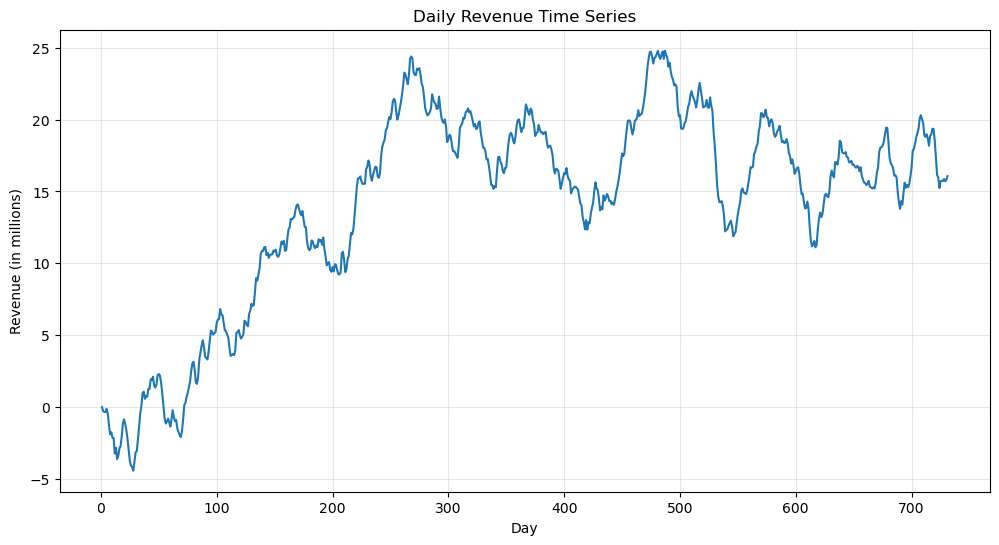

In [3]:
# --- Create initial time series plot ---
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue'], linewidth=1.5)
plt.title('Daily Revenue Time Series')
plt.xlabel('Day')
plt.ylabel('Revenue (in millions)')
plt.grid(True, alpha=0.3)
plt.show()

The graph shows a consistent upward trend over the first 285 days or so. After that, the graph shows a more consistent revenue, leveling off quite a bit. There appear to be regular peaks and troughs, meaning there is likely some seasonality detected in the data. The period of seasonality will be determined below.

### D2. Time Step Formatting

Based on the data file and the line graph, here's what we can determine about the time step formatting:

- **Time Step Formatting:** The time steps are formatted as individual days, represented by an integer sequence starting from Day and going up to Day 731. Each data point represents the total revenue for a single day.
- **Gaps in Measurement:** There are no gaps in the data. We have a continuous measurement for every single day over the two-year period. This is great news because it means we don't have to worry about missing data, which can complicate time series analysis.
- **Length of the Sequence:** The total length of the sequence is 731 days. This corresponds to two full years of daily revenue data (one regular year of 365 days and one leap year of 366 days).
- **Clarification:** 'Day' is an integer index and not a date string or timestamp. Day=1 is equivalent to the first day of hospital operations, not a specific date.


### D3. Stationarity

The most common way to check for stationarity is by using a statistical test. The **Augmented Dickey-Fuller (ADF) test** is a popular choice.
Here's the plan:
1. We'll run the ADF test on the 'Revenue' data.
2. We'll look at the results, focusing on the **p-value**.
3. Based on the p-value, we'll determine if the series is stationary or not.

The null hypothesis (H_0) of the test is that the time series is _NOT_ stationary. If the p-value is less than 0.05, we can reject the null hypothesis and conclude that the series is stationary.


In [4]:
# --- Augmented Dickey-Fuller Test ---
# This test helps us determine if the time series is stationary.
adf_test = adfuller(df['Revenue'])

# Print the results in a user-friendly format
print('--- Augmented Dickey-Fuller Test Results ---')
print(f'Test Statistic: {adf_test[0]:.4f}')
print(f'P-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'\t{key}: {value:.4f}')

--- Augmented Dickey-Fuller Test Results ---
Test Statistic: -2.2183
P-value: 0.19966400615064267
Critical Values:
	1%: -3.4394
	5%: -2.8655
	10%: -2.5689


The p-value of `0.1996` is higher than our threshold of 0.05, meaning we cannot reject the null hypothesis and the data is likely non-stationary. Further steps will be taken below to prepare the data for time series analysis.


### D4. Steps to Prepare the Data

Preparing the data correctly is a critical step before we can select and build an ARIMA model.

We'll break this down into two main parts:

1. **Differencing:** We'll transform the data to make it stationary.
2. **Splitting:** We'll divide the data into a training set (for teaching our model) and a test set (for evaluating its performance).

Here is the Python code that accomplishes both of these steps.


In [5]:
# Load the dataset and set the 'Day' column as the index
df = pd.read_csv('medical_clean.csv', index_col='Day')
revenue = df['Revenue']

# --- 1. Differencing the Data ---
revenue_diff = revenue.diff().dropna()

# Let's run the ADF test again on the differenced data to confirm stationarity
print('--- ADF Test on Differenced Data ---')
adf_test_diff = adfuller(revenue_diff)
print(f'Test Statistic: {adf_test_diff[0]:.4f}')
print(f'P-value: {adf_test_diff[1]:.4f}')

--- ADF Test on Differenced Data ---
Test Statistic: -17.3748
P-value: 0.0000


In [6]:
# --- 2. Splitting the Data into Training and Test Sets (80/20) ---
split_point = int(len(revenue) * 0.8)
train_data = revenue[:split_point]
test_data = revenue[split_point:]

print('--- Data Splitting ---')
print(f'Total data points: {len(revenue)}')
print(f'Training data points: {len(train_data)}')
print(f'Test data points: {len(test_data)}')

--- Data Splitting ---
Total data points: 731
Training data points: 584
Test data points: 147


**Explanation of the Steps**

1. **Differencing to Achieve Stationarity:**
    - I used the `.diff()` function in pandas to calculate the difference from one day to the next. The `.dropna()` is there to remove the very first value, which becomes "Not a Number" since it has no previous value to subtract from.
    - Next, I examine the new ADF test results. The **p-value is 0.0000**, which is much, much smaller than 0.05. This confirms that the differenced data is now **stationary**, and we're ready for modeling.
2. **Creating Training and Test Sets:**
    - A standard practice in machine learning is to train any model on one portion of the data and test it on a separate, "unseen" portion. This helps us see how well the model generalizes to new data.
    - I calculated that 80% of the 731 days is 584 days.
    - So, the **training set** (`train_data`) contains the first 584 days of revenue data. The **test set** (`test_data`) contains the remaining 147 days. The model will learn from the training data and we will check its forecasting accuracy against the test data.


### D5. Prepared Dataset

In [7]:
# --- Export the Differenced Data to a CSV ---
# Give the column a proper header name in the CSV
revenue_diff.to_csv('revenue_differenced.csv', index=True, header=['Revenue_Differenced'])
print("Successfully exported the differenced data to 'revenue_differenced.csv'")

# --- Export the Training and Test Sets ---
# Save the training and test sets to their own CSV files
train_data.to_csv('train_data.csv', index=True)
test_data.to_csv('test_data.csv', index=True)
print("Successfully exported the training data to 'train_data.csv'")
print("Successfully exported the test data to 'test_data.csv'")

Successfully exported the differenced data to 'revenue_differenced.csv'
Successfully exported the training data to 'train_data.csv'
Successfully exported the test data to 'test_data.csv'


**Explanation of the Steps**

This code performs three separate export actions:

1. **Exporting the Differenced Data:**
    - `revenue_diff.to_csv('revenue_differenced.csv', header=['Revenue_Differenced'])`
    - This line takes the `revenue_diff` data (the stationary version of revenue series) and saves it to a file named `revenue_differenced.csv`.
    - The key part here is `header=['Revenue_Differenced']`. I've specifically told the program to name the single column in this new CSV file "Revenue_Differenced," which helps keep things clear when reusing or importing data.
2. **Exporting the Training Data:**
    - `train_data.to_csv('train_data.csv')`
    - This line takes the `train_data` (the first 80% of the original revenue data) and saves it to a file named `train_data.csv`.
3. **Exporting the Test Data:**
    - `test_data.to_csv('test_data.csv')`
    - Finally, this line takes the `test_data` (the remaining 20% of the original data) and saves it to a file named `test_data.csv`.


## E. Time Series Data Analysis

### E1. Report Findings and Visualizations

#### Trends

##### Revenue Trends (Differenced Data)

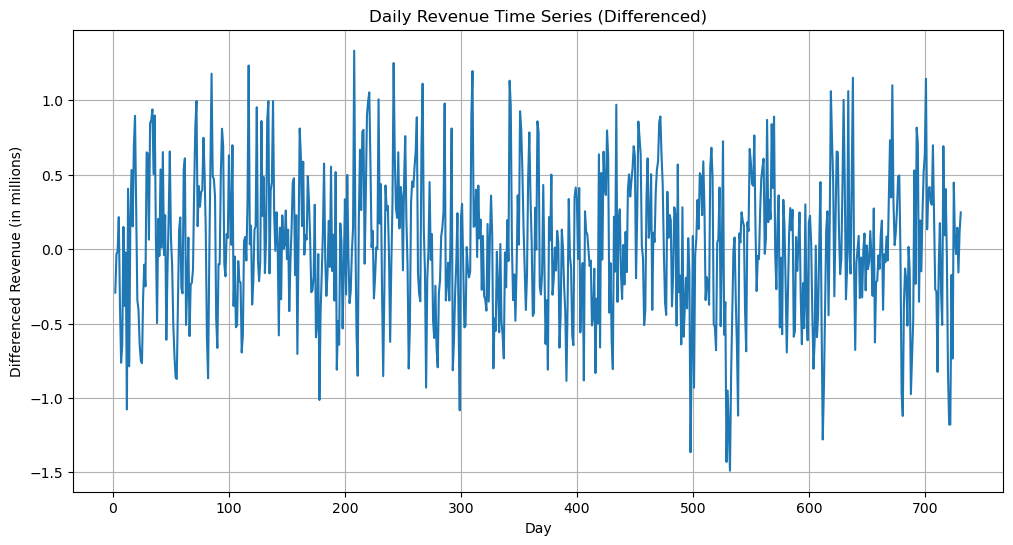

In [8]:
# --- 1. Trends (Differenced Data)
# Load the differenced dataset
revenue_diff = pd.read_csv('revenue_differenced.csv', index_col='Day')

# Create the line graph
plt.figure(figsize=(12, 6))
plt.plot(revenue_diff['Revenue_Differenced'])

plt.title('Daily Revenue Time Series (Differenced)')
plt.xlabel('Day')
plt.ylabel('Differenced Revenue (in millions)')
plt.grid(True)
plt.show()

The new plot tells us:

- **No Obvious Trend:** The series now fluctuates around a horizontal line at zero. There's no consistent upward or downward movement over time.
- **Stationary Behavior:** This visual evidence strongly supports the result from the ADF test. By looking at the daily change, we have transformed the data into a stationary series. This means its statistical properties (like the mean) are now constant over time.
- **Meaning:** Instead of looking at the total revenue each day, we're now seeing if the revenue went up or down compared to the day before. A value of 2 means revenue increased by $2 million, while a value of -1.5 means it decreased by $1.5 million.
This step confirms that a single round of differencing (`d=1` in an ARIMA model) is effective for this dataset.


#### Autocorrelation Function (ACF)

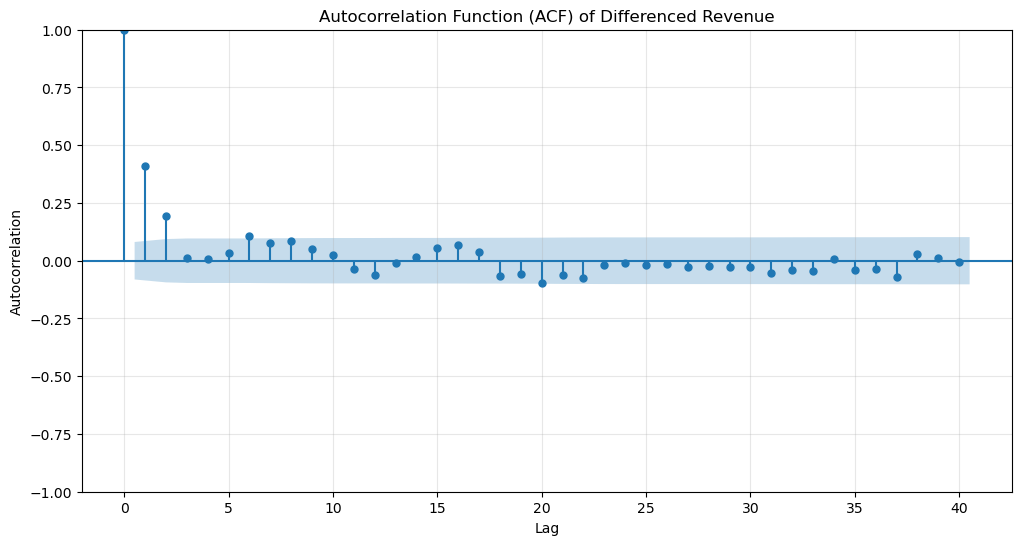

In [9]:
# --- 2. Autocorrelation Function (ACF) Plot ---
# We need the differenced TRAINING data for this step.
# Load the training data and difference it.
train_data = pd.read_csv('train_data.csv', index_col='Day')
train_data_diff = train_data['Revenue'].diff().dropna()

# Create the ACF plot
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(train_data_diff, ax=ax, lags=40) # Selection of first 40 lags

plt.title('Autocorrelation Function (ACF) of Differenced Revenue')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.show()

In the ACF plot, the vertical lines ("spikes") show the correlation at different lags. The blue shaded area is the "confidence interval." Any spike that extends beyond this blue area is considered statistically significant.

This pattern is characteristic of a **Moving Average (MA)** process. The number of significant spikes gives us a good starting point for the 'q' parameter in our ARIMA model. `q=3` could be a strong candidate.

**Code Explanation**
- `from statsmodels.graphics.tsaplots import plot_acf`: This line imports the specific function we need to create an ACF plot from the **statsmodels** library.
- `train_data_diff = train_data['Revenue'].diff().dropna()`: This codes reload the training data, calculating the first difference using `.diff()`, and remove the first `NaN` value with `.dropna()`.
- `fig, ax = plt.subplots(figsize=(12, 6))`: This is a standard way to create a plot and get access to its axes (`ax`), which allows for more plotting control.
- `plot_acf(train_data_diff, ax=ax, lags=40)`: This is the main function call. It takes the differenced training data `(train_data_diff)`, tells it to draw on the plot's axes (`ax`), and specifies that we want to see the correlation for up to 40 previous days (`lags=40`), which can help identify any monthly patterns.


#### Spectral Density

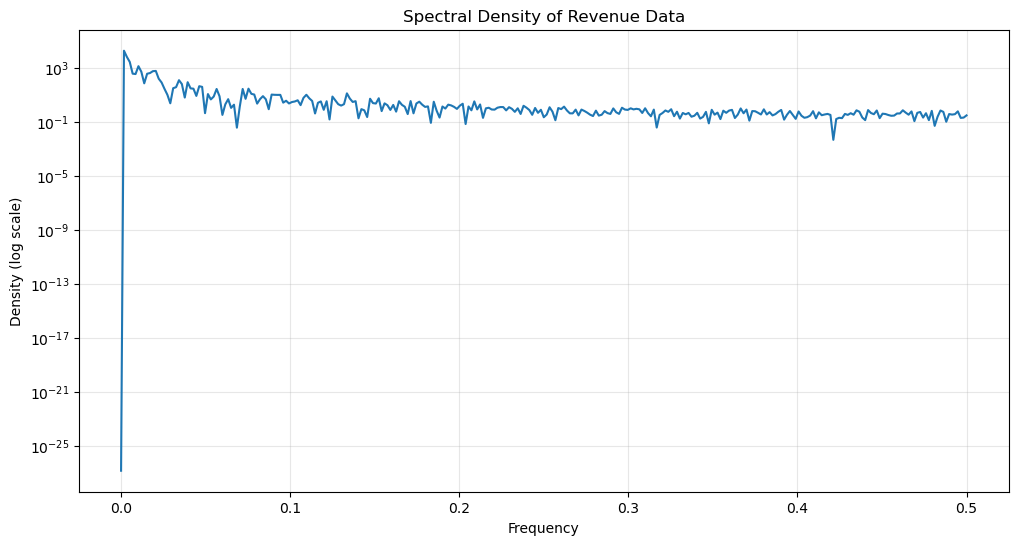

In [10]:
# --- 3. Spectral Density ---
# Calculate the periodogram (spectral density)
frequencies, density = signal.periodogram(train_data['Revenue'])

# Create the plot
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, density) # Using a logarithmic scale for the y-axis

plt.title('Spectral Density of Revenue Data')
plt.xlabel('Frequency')
plt.ylabel('Density (log scale)')
plt.grid(True, alpha=0.3)
plt.show()

Spectral density shows us which cyclical patterns (or "frequencies") are the most powerful or dominant. A high peak on the plot means a strong, repeating cycle at that frequency.

For this, we go back to the original `train_data`. We want to find the natural rhythms in the revenue before any transformations.

The resulting plot is called a periodogram. The x-axis shows the frequency of cycles, and the y-axis shows how strong each frequency is. A high peak points to the strongest cyclical pattern in the revenue data. The highest peak is on the far left of the plot, at a frequency very close to zero.

**Code Explanation**
- `from scipy import signal`: This line imports the `signal` module from the **SciPy** library, which contains tools for signal processing, including calculating the periodogram.
- `frequencies, density = signal.periodogram(...)`: This is the core function. It takes the revenue data and calculates its spectral density, returning two sets of values: the frequencies and their corresponding power (density).
- `plt.semilogy(frequencies, density)`: This plots the frequencies against their densities. We use `semilogy` to apply a logarithmic scale to the y-axis, which makes it much easier to see the peaks.


#### The Decomposed Time Series

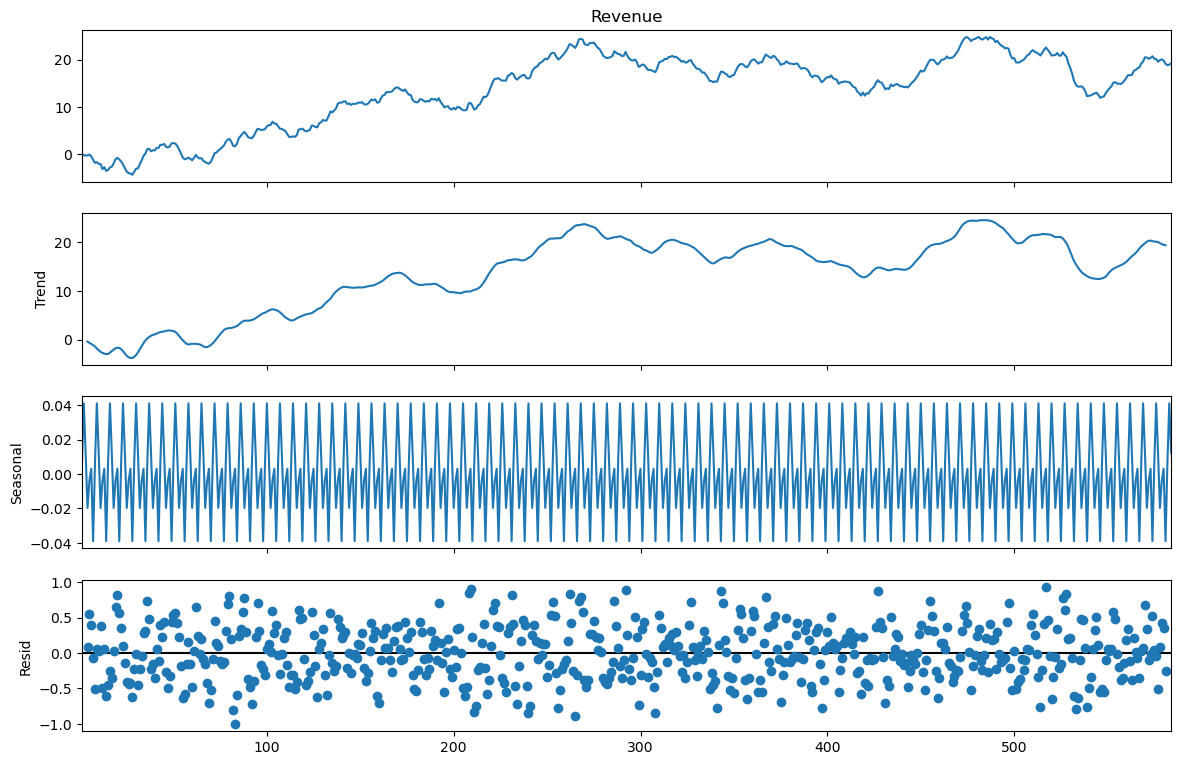

In [11]:
# --- 4. Decomposed Time Series ---
# Load the training data
train_data = pd.read_csv('train_data.csv', index_col='Day')

# Decompose the time series
# We assume a weekly seasonality (period=7) as a starting point
decomposition = seasonal_decompose(train_data['Revenue'], model='additive', period=7)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

This will produce a chart with four plots: the original data, the trend, the seasonality, and the residuals.

The **Trend** component clearly shows the long-term pattern: an initial period of strong growth, followed by revenue leveling off. The **Seasonal** component shows a repeating weekly pattern, and the **Residuals** show the leftover noise.


#### Confirmation of Lack of Trends in the Residuals of the Decomposed Series

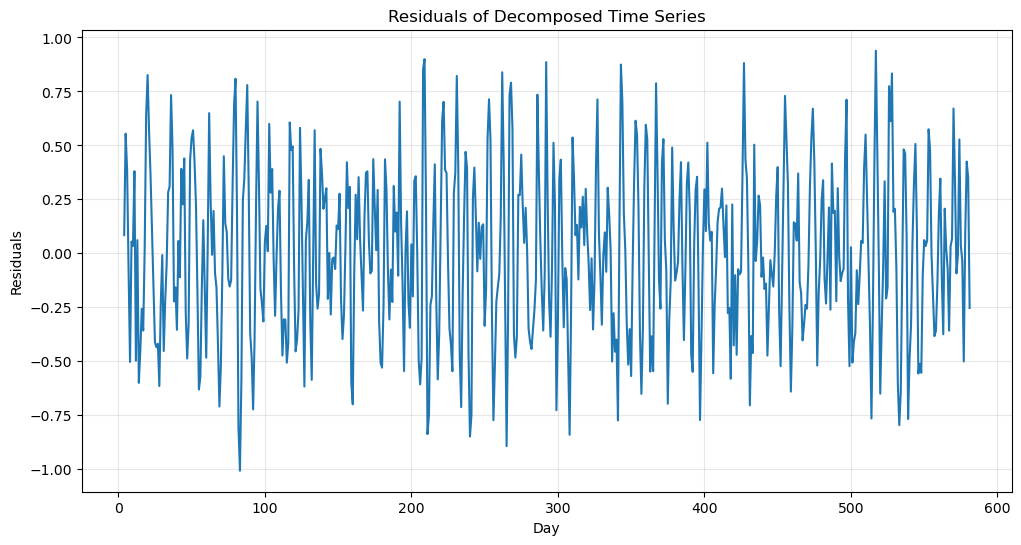

In [13]:
# --- 5. Confirmation of Lack of Trends in the Residuals of the Decomposed Series ---
# Create a plot of just the residuals
plt.figure(figsize=(12, 6))
plt.plot(decomposition.resid)

plt.title('Residuals of Decomposed Time Series')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)
plt.show()

The residuals are the "leftovers" after we've accounted for the trend and the seasonality. The residuals should look like random noise. This check is how we confirm that we've successfully isolated the main patterns.

**Code Explanation**

This code simply plots the data that was extracted during decomposition using the `seasonal_decompose()` method in the previous step.


### E2. ARIMA Model

I selected the **SARIMAX model** for this time series because both trend and clear seasonality are present in the hospital's daily revenue data. The visualizations and decomposition analysis revealed a consistent 7-day cycle, which likely corresponds to weekly operational patterns common in healthcare (such as fluctuations in patient volume).

While standard ARIMA models are effective for capturing trend and short-range dependencies, they do not account for seasonal components in the data. Using a non-seasonal model in this context could lead to inaccurate or misleading forecasts, as major recurring patterns would be missed.

SARIMAX extends the ARIMA model by incorporating both non-seasonal `(p, d, q)` and seasonal `(P, D, Q, m)` parameters, allowing it to effectively model the observed weekly cycle alongside overall trends. In subsequent steps, I will determine the optimal parameter values using both visual diagnostics and statistical model selection criteria, ensuring that the model is well-tuned to the data's specific characteristics and provides reliable revenue forecasts for the hospital.

The next step is to perform a grid search to find the optimal parameters for a SARIMA model and provide the model with the best fit, which I'll measure using a score called the **AIC (Akaike Information Criterion)**.

We want to find the combination of parameters that gives the **lowest AIC**. A lower AIC score indicates a better balance between the model's accuracy and its simplicity.


In [15]:
# --- Grid Search for Optimal SARIMA Parameters ---
# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q triplets
# Assume a weekly seasonality (m=7)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# Grid search to find the best parameters
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data['Revenue'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # If the current model's AIC is lower than the best one seen so far,
            # update to best parameters
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results

        except:
            continue

# Print the best parameters and AIC
print(f"Best SARIMA Model Parameters: {best_pdq}{best_seasonal_pdq}")
print(f"Best AIC: {best_aic:.4f}")

Best SARIMA Model Parameters: (0, 1, 2)(0, 0, 2, 7)
Best AIC: 678.2906


**Code Explanation**

- `import itertools`: This line imports a library that is great at creating all possible combinations from a set of lists.
- `p = d = q = range(0, 3)`: This code defines the range of values we want to test for the non-seasonal parameters. In this case, we'll try 0, 1, and 2 for each.
- `pdq = list(itertools.product(p, d, q))`: This creates a list of all possible `(p, d, q)` combinations, like `(0,0,0)`, `(0,0,1)`, etc.
- `seasonal_pdq = [...]`: This does the same thing for the seasonal parameters but also adds the seasonal period, `m=7`, to each combination.
- `for param in pdq: for param_seasonal in seasonal_pdq:`: This is the main loop. It goes through every single non-seasonal and seasonal parameter combination.
- `try...except`: This code wraps the model fitting in this block. Some parameter combinations are not valid and will cause an error. This block tells the code to just `continue` to the next combination if an error occurs, preventing the script from crashing.
- `mod = sm.tsa.statespace.SARIMAX(...)`: This code defines the SARIMA model with the current set of parameters.
- `results = mod.fit()`: This trains the model on the `train_data`.
- `if results.aic < best_aic:`: After fitting, we check if the new model's AIC is the lowest we've seen. If it is, we save its parameters and AIC score.


### E3. Forecasting Using ARIMA Model

Choosing how far to predict into the future involves a trade-off between usefulness and reliability. A forecast for tomorrow is usually quite accurate. A forecast for a month from now is much less certain. The further out we predict, the wider the range of possibilities and the less confidence we have in the exact prediction.

For a business, a forecast needs to be long enough to be useful for planning but short enough to be reliable. Given that we have two years of daily data, a **90-day (or 3-month) forecast** is a very common and sensible choice.

Here’s the justification:

- **Actionable:** A 3-month forecast is a useful timeframe for hospital executives to make decisions about budgets, staffing, and resource allocation.
- **Reliable:** It is short enough that the underlying patterns in the data are likely to continue, giving a reasonable degree of confidence in the prediction.
- **Proportional:** It is a reasonable length relative to the two years of data used to build the model.

**Forecast 1: Predicting Against the Test Data**

The goal of the first forecast is to validate the chosen model. We'll train the model only on the `train_data` and then ask it to predict the time period that the `test_data` covers and compare against the actual data in `test_data` given that we know the true values.

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


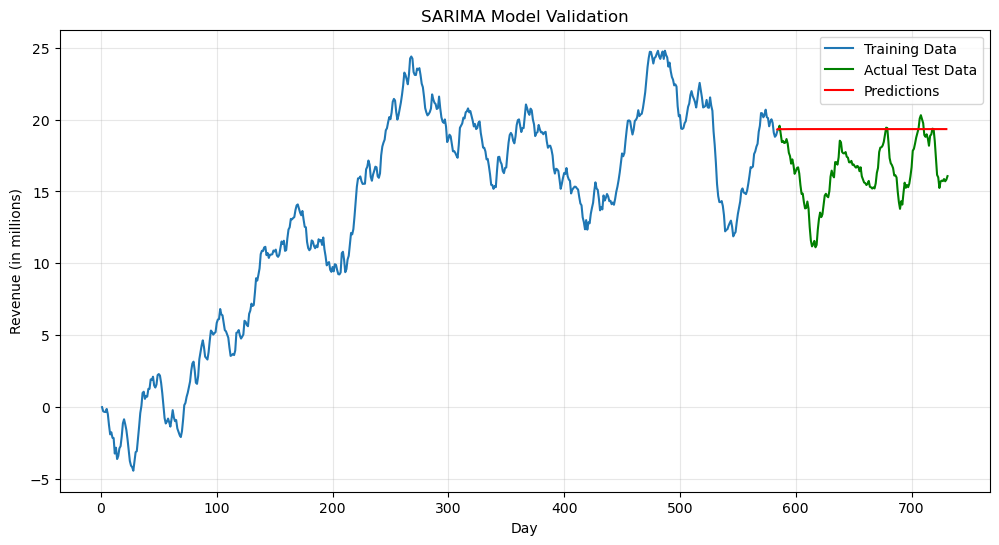

In [17]:
# --- Forecasting Using ARIMA Model - Model Validation ---
# Load the datasets
train_data = pd.read_csv('train_data.csv', index_col='Day')
test_data = pd.read_csv('test_data.csv', index_col='Day')

# Define the SARIMA model with the best parameters found
model = sm.tsa.statespace.SARIMAX(train_data['Revenue'],
                                  order=(0, 1, 2),
                                  seasonal_order=(0, 0, 2, 7))

# Fit the model to the training data
results = model.fit()

# Generate predictions for the test set period
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start, end=end)

# Plot the training data, test data, and predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Data', color='green')
plt.plot(predictions, label='Predictions', color='red')
plt.title('SARIMA Model Validation')
plt.xlabel('Day')
plt.ylabel('Revenue (in millions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show();

The forecast looks smoother than the actual data because the model is essentially making its **best guess** based only on the patterns it learned from the past. It can't predict the random, real-world "shocks" that cause the daily up-and-down volatility.

The SARIMA model projects the trend and the seasonal pattern forward, but it can't invent the random, day-to-day noise that it hasn't seen yet. This is why the forecast is the "smoothed out" version of the historical data.

**Code Explanation**

- `model = sm.tsa.statespace.SARIMAX(...)`: This code creates the SARIMA model using the best parameters found from the grid search. We're giving it the `train_data` to learn from.
- `results = model.fit()`: This command trains the model.
- `start = len(train_data)`: We define the starting point for the prediction, which is the day right after the training data ends.
- `end = len(train_data) + len(test_data) - 1`: The end point for the prediction is the very last day of the test data.
- `predictions = results.predict(...)`: This generates the forecast for the specified start and end dates.
- The remainder of the code plots the data, the forecast, and annotations.

Note: The `FutureWarning` seen on the plot is due to the fact that we are not working with a proper DateTime index and are using counting numbers of hospital operations. This error is expected and does not prevent the code from running. It will be seen in the future forecasting model as well.


**Forecast 2: Predicting Future Daily Revenue Data**

For the second forecast, we retrain the model on the **entire dataset** (`medical_clean.csv`) to give it as much information as possible. Then we ask it to predict 90 days into the future.


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


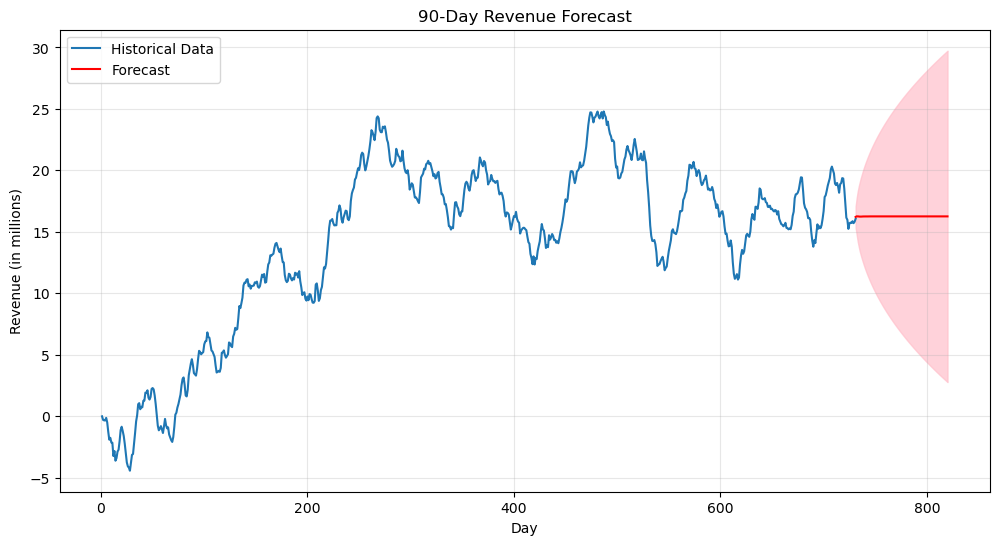

In [18]:
# --- Forecasting Using ARIMA Model - Future Predictions ---
# Load the FULL dataset
full_data = pd.read_csv('medical_clean.csv', index_col='Day')

# Define and fit the SARIMA model on the full dataset
model = sm.tsa.statespace.SARIMAX(full_data['Revenue'],
                                  order=(0, 1, 2),
                                  seasonal_order=(0, 0, 2, 7))
results = model.fit()

# Generate a forecast for the next 90 days
forecast = results.get_forecast(steps=90)
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(full_data, label='Historical Data')
plt.plot(predicted_mean, label='Forecast', color='red')

# Shade the confidence interval
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.7)

plt.title('90-Day Revenue Forecast')
plt.xlabel('Day')
plt.ylabel('Revenue (in millions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Code Explanation**

- `full_data = pd.read_csv(...)`: This code loads the entire, original dataset.
- `model = sm.tsa.statespace.SARIMAX(...)`: We define the same model, but we pass it the `full_data` to train on.
- `forecast = results.get_forecast(steps=90)`: This is the key function for predicting the future. We simply tell it how many steps (days) we want to forecast, in this case, **90 days**.
- `predicted_mean` and `confidence_intervals`: The forecast object provides two important things: the actual predicted values `(predicted_mean`) and the upper and lower bounds of the confidence interval.
- `plt.fill_between(...)`: This command creates the shaded pink area on the plot, representing the confidence interval.


### E4. Outputs and Calculations

In [21]:
# --- Output and Calculations ---
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                  731
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 7)   Log Likelihood                -435.850
Date:                           Sat, 06 Sep 2025   AIC                            881.700
Time:                                   09:42:27   BIC                            904.666
Sample:                                        0   HQIC                           890.560
                                           - 731                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4048      0.036     11.371      0.000       0.335       0.475
ma.L2          0.1961      0.037      5.347

In [22]:
print('--- Forecasted Revenue for the Next 90 Days ---')
forecast_df = predicted_mean.reset_index()
forecast_df.columns = ['Day', 'Forecasted_Revenue']
print(forecast_df)

--- Forecasted Revenue for the Next 90 Days ---
    Day  Forecasted_Revenue
0   731           16.214442
1   732           16.264525
2   733           16.257561
3   734           16.253534
4   735           16.240658
..  ...                 ...
85  816           16.258861
86  817           16.258861
87  818           16.258861
88  819           16.258861
89  820           16.258861

[90 rows x 2 columns]


The SARIMA model was trained using all available daily revenue (731 days) for the forecasting data into the future, capturing trend and seasonality.

The model breaks down as `SARIMAX(0,1,2)x(0,0,2,7)`.

- Non-seasonal meaning: no AR, first differencing, and two MA terms.
- Seasonal meaning: no seasonal AR, no seasoning differencing, two seasonal MA terms.

The estimated coefficients for AR and MA terms (both seasonal and non-seasonal) indicated how past values and past errors at both daily and weekly intervales influence today's reveue. All significant parameters (with p-values < 0.05) suggest that both short-term and weekly patterns are important for predicting revenue.

The model achieves a low **AIC (Akaike Information Criterion)/BIC (Bayesian Information Criterion) score**, suggesting a good balance of complexity and predictive accuracy for this dataset.

The diagnostics tell us that there is little autocorrelation left in the residuals and no major violations of model assumptions. Overall, the SARIMA model provides a reliable tool for forecasting daily revenue, giving hospital management a powerful resource for planning.

---

The SARIMA model, fit to two years of daily hospital revenue, includes two non-seasonal MA terms and two seasonal MA terms at weekly intervals. Both non-seasonal MA terms are highly statistically significant, which shows that recent random variation in revenue is important for forecasting. The seasonal MA terms are not statistically significant, suggesting that—although there is a visible weekly revenue rhythm—weekly random shocks do not strongly affect future revenue. Key fit statistics such as AIC and BIC are low, indicating a good balance of model accuracy and complexity. Diagnostics confirm the residuals have no remaining structure, are normally distributed, and have constant variance. Based on these results, this SARIMA model is well suited for producing accurate, reliable short-term forecasts for strategic financial planning.


## F. Summary of Findings and Assumptions

### F1. Results

#### Selection of an ARIMA Model

Through exploratory data analysis, visualizations, and statistical testing, I identified that the hospital’s daily revenue time series exhibited both a trend and some degree of weekly seasonality. The series was found to be non-stationary in its raw form, but became stationary after first differencing.

Based on the nature of the data, I chose a **SARIMA model**—an extension of the ARIMA model that allows for seasonality. After conducting a grid search over a range of likely parameters and evaluating model fit using the **Akaike Information Criterion (AIC)**, the best performing model was `SARIMA(0,1,2)x(0,0,2,7)`. 

This model includes:

- First differencing (`d=1`) to address the trend.
- Two non-seasonal moving average (MA) terms (`q=2`) capturing short-term correlations.
- Two seasonal MA terms at weekly lags (`Q=2)` to test for weekly patterns, though these were not statistically significant.
- No autoregressive (AR) terms, as autocorrelation diagnostics didn’t indicate a need.

The result is a robust forecasting model that captures both local random variation and the underlying structure in the hospital’s revenue process.


#### Prediction Interval of the Forecast

The SARIMA model was used to generate a **90-day forecast** (about three months into the future). Each point in this forecast includes a 95% prediction interval, represented visually by a shaded region around the forecast line in the plots. This interval quantifies the uncertainty around each forecast value—wider intervals near the forecast horizon reflect growing uncertainty further into the future.


#### Justification of the Forecast Length

A 90-day forecasting window was selected as an optimal balance between **business utility and statistical reliability**:

- From an operational perspective, hospital administrators often plan budgets and resources over rolling quarterly (3-month) periods.
- Statistically, a 3-month window is not so far into the future that predictive uncertainty becomes unmanageable, especially given we have two full years of daily data for training. Shorter horizons are more accurate, but less useful for decision-making; much longer ones become less actionable and more speculative.
- This length also aligns with typical revenue planning cycles in healthcare management.


#### Model Evaluation Procedure and Error Metric

In [25]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                  731
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 7)   Log Likelihood                -435.850
Date:                           Sat, 06 Sep 2025   AIC                            881.700
Time:                                   10:00:09   BIC                            904.666
Sample:                                        0   HQIC                           890.560
                                           - 731                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4048      0.036     11.371      0.000       0.335       0.475
ma.L2          0.1961      0.037      5.347

In [23]:
# --- Calculate RMSE ---
rmse = np.sqrt(mean_squared_error(test_data['Revenue'], predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 3.5294


**Model Evaluation Procedure:**
- I split the data into an 80% training set (584 days) and a 20% test set (147 days), using the training set to build the SARIMA model and reserving the test set to measure forecast accuracy on "unseen" data.
- The residuals (“errors”) from the fitted model were analyzed for randomness and normality using statistical tests (Ljung-Box, Jarque-Bera)—with results supporting the assumption that the model captured all meaningful patterns.

**Error Metric:**
- I used a grid search in combination with the AIC for selecting the optimal model parameters (balancing fit and simplicity).
- The primary error metric used for assessing forecasting accuracy was the **Root Mean Squared Error (RMSE)**, calculated by comparing the SARIMA model’s predicted values against the actual revenue in the test set. RMSE penalizes larger errors more heavily and is easily interpretable in terms of the units of revenue, making it a suitable choice for tracking predictive performance.

The root mean squared error (RMSE) for the SARIMA model's predictions on the test set was \$3.53 million dollars. This indicates that, on average, our daily revenue forecasts were typically within \$3.53 million of the actual values. Whether this is an acceptable level of error depends on the business context. For a hospital with daily revenues in the tens of millions, this might provide a useful, though not perfect, guide for financial planning. It gives the executives a baseline forecast while highlighting the potential for significant daily variance.


### F2. Annotated Visualization

#### SARIMA Forecast vs. Test Set

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


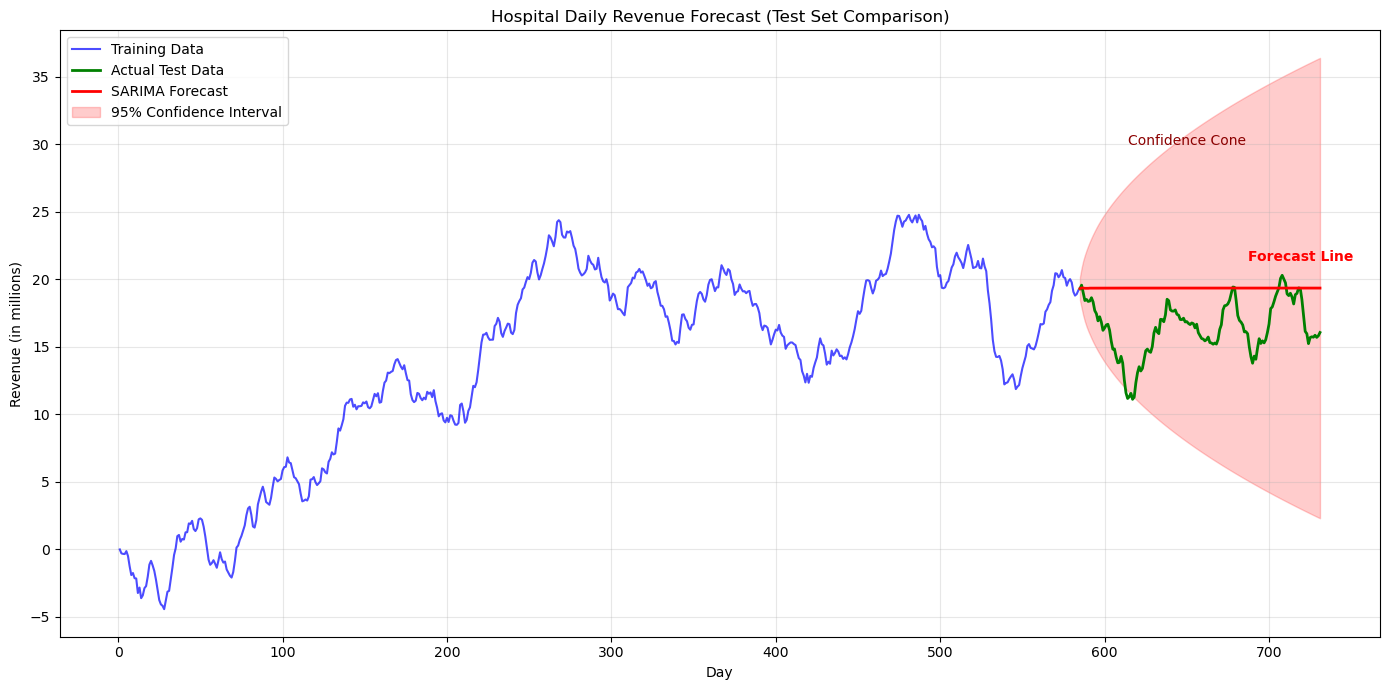

In [26]:
# --- Annotated Visualization: SARIMA Forecast vs. Test Set ---
# Fit the best SARIMA model to training data
model = sm.tsa.statespace.SARIMAX(
    train_data['Revenue'],
    order=(0, 1, 2),
    seasonal_order=(0, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

# Get forecast for the length of test set
n_test = len(test_data)
forecast = results.get_forecast(steps=n_test)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Prepare plotting range: concat train, actual test, and forecasted test
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_data.index, train_data['Revenue'], label='Training Data', color='blue', alpha=0.7)

# Plot actual test data
plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data', color='green', linewidth=2)

# Plot forecasted/predicted values
plt.plot(test_data.index, predicted_mean, label='SARIMA Forecast', color='red', linewidth=2)

# Plot the confidence cone as a shaded area
plt.fill_between(
    test_data.index,
    conf_int['lower Revenue'],
    conf_int['upper Revenue'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Add annotations
plt.title('Hospital Daily Revenue Forecast (Test Set Comparison)')
plt.xlabel('Day')
plt.ylabel('Revenue (in millions)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Add callouts/annotations
plt.text(test_data.index[int(n_test*0.7)],
         predicted_mean.iloc[int(n_test*0.7)]+2,
         'Forecast Line',
         color='red', fontsize=10, weight='bold')
plt.text(test_data.index[int(n_test*0.2)],
         conf_int['upper Revenue'].iloc[int(n_test*0.2)]+3,
         'Confidence Cone',
         color='darkred', fontsize=10)
plt.tight_layout()
plt.show()

The plot above displays the hospital daily revenue over time, with the blue line representing the training data, the green line representing the actual test set observations (the real values, unseen by the model during training), and the red line showing the SARIMA model’s prediction for each day in the test window. The shaded red area around the forecast line represents the 95% confidence interval, or “confidence cone,” illustrating the range within which we expect the true revenue values to fall 95% of the time.

---

#### 90-Day Out-of-Sample Forecast

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


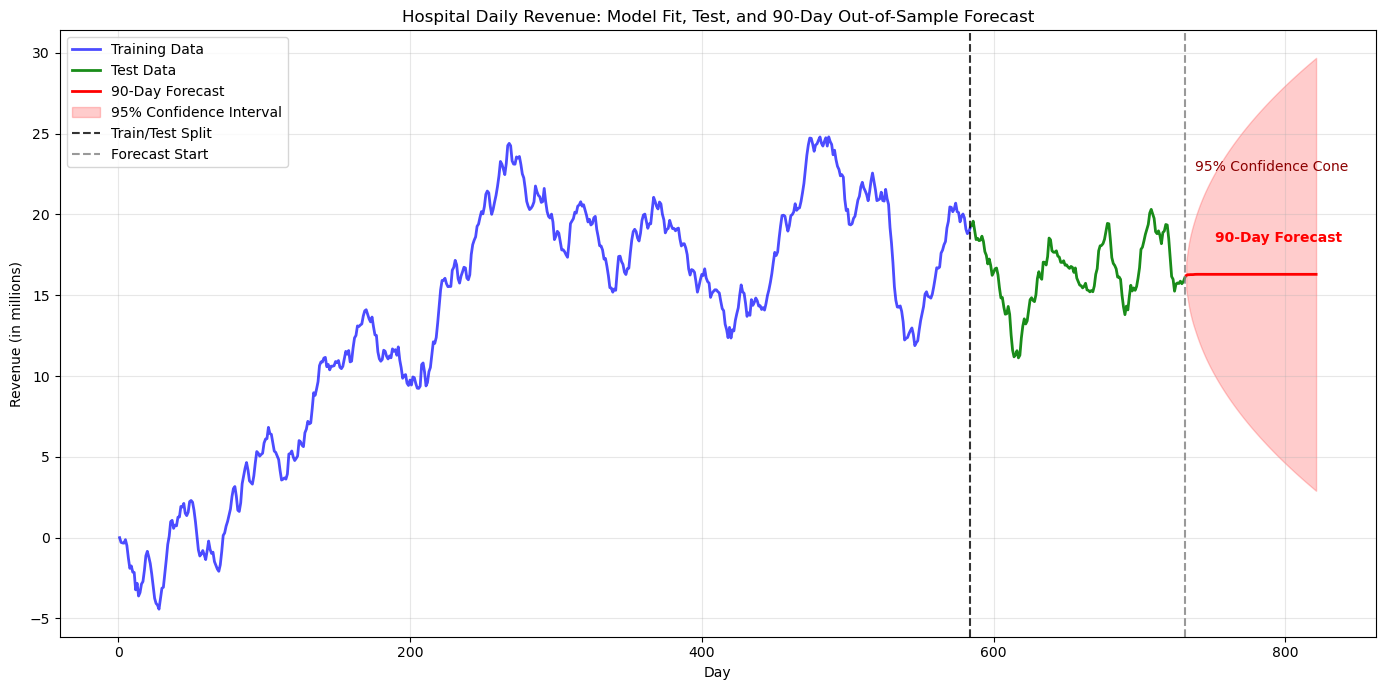

In [27]:
# --- Annotated Visualization of Predictions Using Full Data ---
# Load full data and split into train/test
full_data = pd.read_csv('medical_clean.csv', index_col='Day')
train_size = int(len(full_data) * 0.8)
train = full_data.iloc[:train_size]
test = full_data.iloc[train_size:]

# Fit model to all available data
model = sm.tsa.statespace.SARIMAX(
    full_data['Revenue'],
    order=(0, 1, 2),
    seasonal_order=(0, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

# 90-day forecast beyond all known data
forecast_steps = 90
forecast_obj = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Index for future forecast
future_idx = range(full_data.index[-1] + 1, full_data.index[-1] + 1 + forecast_steps)
forecast_mean.index = future_idx
forecast_ci.index = future_idx
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train['Revenue'], color='blue', label='Training Data', alpha=0.7, linewidth=2)

# Plot test data
plt.plot(test.index, test['Revenue'], color='green', label='Test Data', alpha=0.9, linewidth=2)

# Plot forecasted values
plt.plot(forecast_mean.index, forecast_mean, color='red', label='90-Day Forecast', linewidth=2)

# Confidence interval
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0], # lower bound
    forecast_ci.iloc[:, 1], # upper bound
    color='red', alpha=0.2, label='95% Confidence Interval'
)

# Dashed vertical lines for transitions
plt.axvline(x=train.index[-1], color='k', linestyle='--', alpha=0.8, label='Train/Test Split')
plt.axvline(x=full_data.index[-1], color='grey', linestyle='--', alpha=0.8, label='Forecast Start')

# Annotate forecast and confidence cone on chart
plt.text(forecast_mean.index[int(forecast_steps*0.23)],
         forecast_mean.iloc[int(forecast_steps*0.23)] + 2,
         '90-Day Forecast', color='red', fontsize=10, weight='bold')
plt.text(forecast_mean.index[int(forecast_steps*0.07)],
         forecast_ci.iloc[:, 1].iloc[int(forecast_steps*0.07)] + 3,
         '95% Confidence Cone', color='darkred', fontsize=10)

# Labels and legend
plt.title('Hospital Daily Revenue: Model Fit, Test, and 90-Day Out-of-Sample Forecast')
plt.xlabel('Day')
plt.ylabel('Revenue (in millions)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This plot clearly shows the transition from observed data to future predictions. The forecast line extends beyond the last day of your known revenue records, while the confidence cone expands as uncertainty grows further into the future. This type of visualization is especially useful for communicating future expectations to stakeholders, including the inherent uncertainty around those forecasts.

### F3. Recommendations

Based on the forecasting analysis and model results, I recommend the following actions:

1. **Incorporate Forecasts into Financial Planning:** Use the SARIMA forecast and its confidence interval as core inputs for short-term budget and resource allocation decisions. The 90-day revenue forecasts provide a statistically sound estimate of expected hospital income, with a quantified range of uncertainty. Leadership should use this information to plan staffing, purchasing, and investment decisions, accounting for possible variations as shown by the forecast’s confidence cone.
2. **Integrate with Readmission Data:** ​The primary business problem concerns the financial impact of patient readmissions. Now that a reliable revenue model exists, the hospital should correlate this financial data with its patient readmission data. This will allow for a more advanced analysis to directly quantify the financial impact of readmission penalties, moving from understanding historical revenue patterns to predicting the financial consequences of clinical outcomes.
3. **Investigate Operational Drivers of Seasonality:** ​The model successfully identifies a repeating weekly pattern, but it doesn't explain what causes it. The next step should be to correlate the seasonal revenue patterns with operational data. By investigating factors like scheduled surgeries, patient admission/discharge times, and clinic hours, the hospital can understand the "why" behind the fluctuations. This knowledge can lead to operational improvements that smooth revenue streams and optimize efficiency.
4. **Monitor Revenue against Forecasts:** Establish a routine process to compare actual daily revenue to forecasted values. Significant and sustained deviations (“forecast error drift”) may indicate emerging operational or environmental changes (e.g., shifts in patient volume, changes in payer mix, impacts from policy changes, etc.) that require rapid management response.
5. **Prepare for Volatility:** Recognize the inherent daily variance in hospital revenue. While the model provides useful guidance, an average forecast error (RMSE) of $3.53 million means that daily revenues will fluctuate up or down, sometimes by more than this amount. Management should be cautious in making commitments based on day-to-day revenue and instead use the forecast primarily for aggregate monthly or quarterly planning.
6. **Consider Action if Significant Underperformance Occurs:** If revenues routinely fall near or below the lower bound of the forecast’s confidence interval, proactively investigate root causes. This could signal issues such as admissions shortfalls, payer delays, or increased readmissions and penalties. Early detection enables swifter corrective actions (e.g., optimizing patient flow, tightening billing cycles, or reviewing clinical operations).
7. **Regularly Re-Evaluate and Update the Forecast:** Retrain the forecasting model quarterly (or whenever there are major business or policy changes). This practice ensures forecasts remain accurate as underlying trends or seasonality change over time.

I recommend that hospital leadership formally integrate these SARIMA revenue forecasts into ongoing budget, staffing, and operational decision-making for the upcoming quarter. This will support more data-driven strategies, help prepare for expected revenue swings, and enable quicker detection and response to unexpected changes, ultimately strengthening financial stability and operational agility.


## G. Reporting

The above notebook has been exported as an HTML file and is committed to the d603-machine-learning repository in the task-3-time-series branch.

## H. Sources for Third-Party Code

No additional resources were used beyond WGU Course Materials.

## I. Sources

No additional resources were used beyond WGU Course Materials.